In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
import tmap as tm

### 1. Load dataset

In [2]:
url = "https://raw.githubusercontent.com/DIFACQUIM/Art-Driven-by-Visual-Representations-of-Chemical-Space-/main/Datasets/01_ground_flavors_16JUNE2023.csv"
DATA = pd.read_csv(url)
DATA.head(2)

,COMPOUND_ID,NAME_FOOD_DB,NEW_SMILES,FLAVOR_ID,NAME_FLAVOR,FLAVOR_GROUP
0,411,Geranyl 3-methylbutanoate,CC(C)=CCCC(C)=CCOC(=O)CC(C)C,59.0,green,green
1,423,5Z-Octenyl acetate,CCC=CCCCCOC(C)=O,59.0,green,green


### 2. Show overlapping compounds

Text(0.5, 0.98, 'COMPOUNDS')

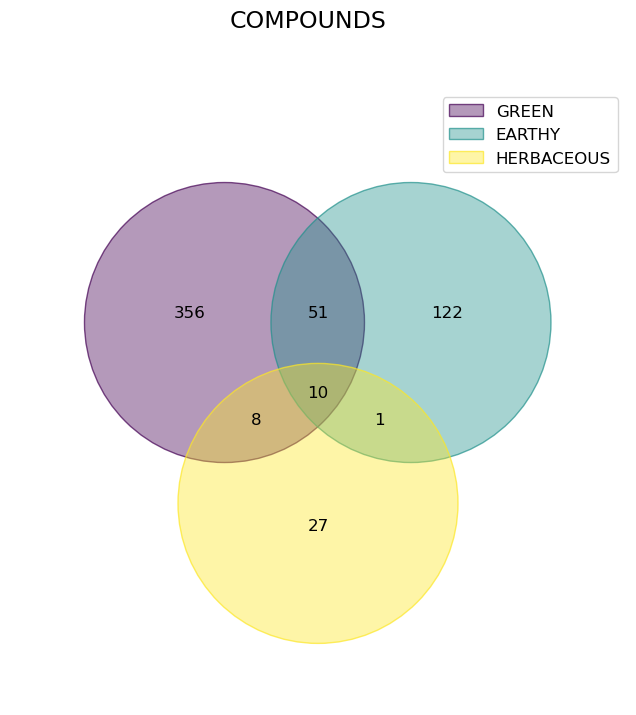

In [3]:
from venn import venn
import matplotlib.pyplot as plt
# Split dataset
GREEN = DATA[DATA["FLAVOR_GROUP"]==str('green')]
EARTHY = DATA[DATA["FLAVOR_GROUP"]==str('earthy')]
HERBACEOUS = DATA[DATA["FLAVOR_GROUP"]==str('herbaceous')]
# Generate venn diagram
COMPOUNDS = {"GREEN":set(GREEN["NEW_SMILES"]),
             "EARTHY":set(EARTHY["NEW_SMILES"]),
             "HERBACEOUS":set(HERBACEOUS["NEW_SMILES"])}
COMPOUNDS = venn(COMPOUNDS, fontsize=12)
plt.suptitle("COMPOUNDS", fontsize=17)

In [4]:
# Show initial labels
print(set(list(DATA["FLAVOR_GROUP"])))

{'earthy', 'green', 'herbaceous'}


In [5]:
# Generate new labels of overlapping compounds
FinalSet = []
for name, group in DATA.groupby(["NEW_SMILES"]):
    label = list(group["FLAVOR_GROUP"])
    label.sort()
    FinalSet.append([name, "-".join(label)])

DATA = pd.DataFrame(FinalSet, columns=["NEW_SMILES", "FLAVOR_GROUP"])
print(DATA.shape)
DATA.head()

(575, 2)


/tmp/ipykernel_8961/3755106438.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in DATA.groupby(["NEW_SMILES"]):


,NEW_SMILES,FLAVOR_GROUP
0,C1CCC(SSC2CCCCC2)CC1,earthy
1,C1SSCSSS1,earthy
2,C=C(C)C1C=CC(C)C(=O)C1,herbaceous
3,C=C(C)C1CC=C(C)C(O)C1,herbaceous
4,C=C(C)C1CC=C(CO)CC1,green


In [6]:
# new labels of overlapping compounds
print(set(list(DATA["FLAVOR_GROUP"])))

{'earthy', 'green-herbaceous', 'earthy-green-herbaceous', 'green', 'earthy-herbaceous', 'herbaceous', 'earthy-green'}


### 3. Calculate t-MAP

In [7]:
from rdkit.Chem import AllChem, MACCSkeys
from rdkit import Chem
import tmap as tm
#######################################################################################################
#MACCS keys
fps = [[int(y) for y in MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)).ToBitString()] for x in DATA["NEW_SMILES"]]
fps = [np.array(x) for x in fps]
##############################################################################################################
# Generate t-MAP
fps = [tm.VectorUchar(x) for x in fps]
enc = tm.Minhash(1024)
lf=tm.LSHForest(1024, 64, store=True) 
lf.batch_add(enc.batch_from_binary_array(fps))
lf.index()
cfg = tm.LayoutConfiguration()
cfg.node_size = 1/40 
cfg.k = 20 
cfg.kc = 10 
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

# Define coordinates
DATA["x"] = x
DATA["y"] = y

In [8]:
DATA.head()

,NEW_SMILES,FLAVOR_GROUP,x,y
0,C1CCC(SSC2CCCCC2)CC1,earthy,-0.335428,-0.332746
1,C1SSCSSS1,earthy,-0.272506,-0.336844
2,C=C(C)C1C=CC(C)C(=O)C1,herbaceous,0.224360,-0.402547
3,C=C(C)C1CC=C(C)C(O)C1,herbaceous,0.224722,-0.396665
4,C=C(C)C1CC=C(CO)CC1,green,0.395753,-0.155350


In [9]:
# Print new labels
print(set(list(DATA["FLAVOR_GROUP"])))

{'earthy', 'green-herbaceous', 'earthy-green-herbaceous', 'green', 'earthy-herbaceous', 'herbaceous', 'earthy-green'}


In [10]:
# Define color function according new labels
def color(label):
    if label == 'green':
        return int(1)
    elif label == 'earthy':
        return int(2)
    elif label == 'herbaceous':
        return int(3)
    if label == 'earthy-green':
        return int(4)
    elif label == 'earthy-herbaceous':
        return int(5)
    elif label == 'green-herbaceous':
        return int(6)
    elif label == 'earthy-green-herbaceous':
        return int(7)

In [11]:
DATA["COLOR"] = [color(x) for x in DATA["FLAVOR_GROUP"]]

In [12]:
DATA.head(2)

,NEW_SMILES,FLAVOR_GROUP,x,y,COLOR
0,C1CCC(SSC2CCCCC2)CC1,earthy,-0.335428,-0.332746,2
1,C1SSCSSS1,earthy,-0.272506,-0.336844,2


### 4. Plot t-MAP

In [13]:
from faerun import Faerun
from matplotlib.colors import ListedColormap
# Relate index and new labels
legend_labels = [
(7,'earthy-green-herbaceous'),
(6,'green-herbaceous'),
(5,'earthy-herbaceous'),
(4,'earthy-green'),
(3,'herbaceous'),
(2,'earthy'),
(1,'green'),
]

# Define color palette
custom_cmap = ListedColormap(['#90ac4d','#d4a572','#579980',
                              '#fae9ea', '#fae9ea', '#fae9ea', '#fae9ea'])
# Generate scatter plot
faerun = Faerun(view="front", coords=False)
faerun.add_scatter(
    "ESOL_Basic",
    {   "x": x, 
        "y": y,
        "c": list(DATA.COLOR.values),
        "labels": DATA["NEW_SMILES"]
    },
    point_scale=12,
    colormap=[custom_cmap],
    has_legend=True,
    legend_labels=legend_labels,
    legend_title = 'Data set',
)

# Plot t-MAP and save file.html
faerun.plot('Ground_flavors_TMAP_MACCSkeys', template="smiles", notebook_height=1000)

/home/ana/Documentos/DANIELA/Food DB/Ground_flavors_TMAP_MACCSkeys.html